# Let’s Reproduce GPT-2 (124M)

## Andrej Karpathy GPT Course - Neural Networks: Zero to Hero

### Lesson 10 - Let's Reproduce GPT-2 (124M): Section 1 - Build GPT-2

+ YouTube video:
    + https://www.youtube.com/watch?v=l8pRSuU81PU

#####  Jun 9, 2024

##### Andrej's Video Comments
We reproduce the GPT-2 (124M) from scratch. This video covers the whole process: First we build the GPT-2 network, then we optimize its training to be really fast, then we set up the training run following the GPT-2 and GPT-3 paper and their hyperparameters, then we hit run, and come back the next morning to see our results, and enjoy some amusing model generations. Keep in mind that in some places this video builds on the knowledge from earlier videos in the Zero to Hero Playlist (see my channel). You could also see this video as building my nanoGPT repo, which by the end is about 90% similar.

+ Full course details: 
    + https://karpathy.ai/zero-to-hero.html
+ GitHub repository with all the changes in this video as individual commits (build-nanogpt)
    + https://github.com/karpathy/build-nanogpt
+ GitHub repository of GPT-2 based on the this "Let's Reproduce GPT-2" tutorial by user Lxrd-AJ
    + https://github.com/Lxrd-AJ/GPT2
+ nanoGPT repository
    + https://github.com/karpathy/nanoGPT
+ LLM.c Repository
    + https://github.com/karpathy/llm.c

### YouTube video contents: Section 1 - Build GPT-2

Some of the code implementation for the later chapters can be found in the Section 2 Notebook

#### Chapters
+ 00:00:00 - intro: Let’s reproduce GPT-2 (124M)
+ 00:03:39 - exploring the GPT-2 (124M) OpenAI checkpoint
+ 00:13:47 - SECTION 1: implementing the GPT-2 nn.Module
+ 00:28:08 - loading the hugging Face/GPT-2 parameters
+ 00:31:00 - implementing the forward pass to get logits
+ 00:33:31 - sampling init, prefix tokens, tokenization
+ 00:37:02 - sampling loop
+ 00:41:47 - sample, auto-detect the device
+ 00:45:50 - let’s train: data batches (B,T) → logits (B,T,C)
+ 00:52:53 - cross entropy loss
+ 00:56:42 - optimization loop: overfit a single batch
+ 01:02:00 - data loader lite
+ 01:06:14 - parameter sharing wte and lm_head
+ 01:13:47 - model initialization: std 0.02, residual init

In [5]:
# Check functorch imports and check torch version and GPU support

import torch

# functorch lives inside torch >= 2.0 as torch.func
try:
    import torch.func as functorch
except Exception:
    import functorch  # for older torch installs

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch version: 2.5.1
CUDA available: True
Device: NVIDIA GeForce RTX 3090


In [6]:
# Check Python location for activation
import sys
print(sys.executable)

C:\Users\johns\anaconda3\envs\gpt-lab\python.exe


## Load existing GPT-2 model to experiment with it a little

This tutorial will need `transformers` and `tiktoken` to be installed which can be done using a Conda shell by typing
```
pip install transformers
pip install tiktoken
```
You may run in to an issue with an error message: `ImportError: cannot import name 'BaseFileLock' from 'filelock' (unknown location)`. This can be fixed by upgrading filelock in the conda shell and restarting the kernel:
```
pip install --upgrade filelock

```

In [23]:
# Check tiktoken imports
import tiktoken

# load GPT-2 model from Hugging Face and print out each of the layers of the neural network
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2")   # 124M        USe "gpt2-xl" to load the larger 1.5B model
sd_hf = model_hf.state_dict()                        # Just load raw tensors

for k,v in sd_hf.items():
    print(k, v.shape) 

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

We will examine this schema when building our own GPT-2 model so we can recreate some of the structures. This will allow us to re-use these weights without us having to fully train our own model:
```
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])

In [12]:
sd_hf["transformer.wte.weight"].view(-1)[:20]              # Flatten positional embeddings taking just 20 elements

tensor([-0.1101, -0.0393,  0.0331,  0.1338, -0.0485, -0.0789, -0.2398, -0.0895,
         0.0253, -0.1074, -0.1811, -0.0672,  0.0739, -0.0161,  0.0117,  0.1245,
        -0.0020, -0.0815,  0.0338,  0.2365])

torch.Size([1024, 768])


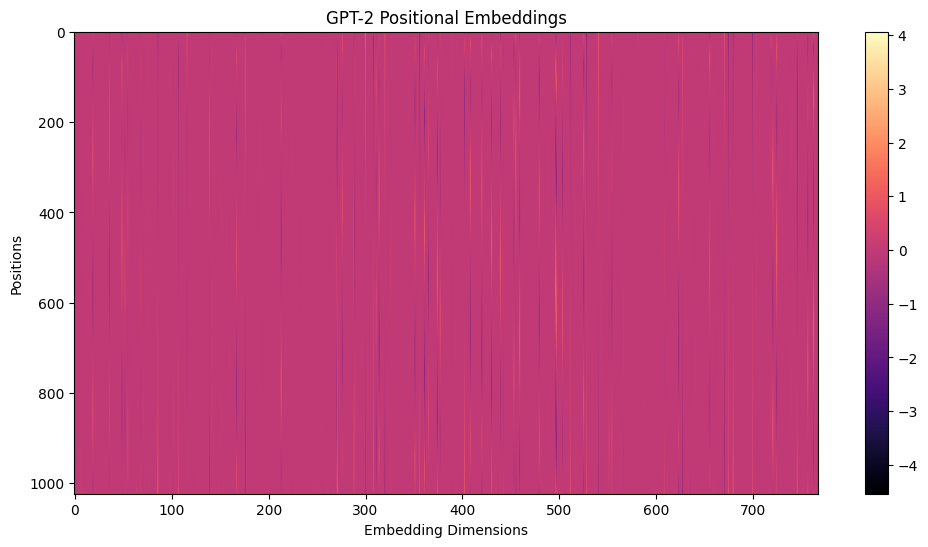

In [14]:
# Plot the position embeddings
import matplotlib.pyplot as plt
%matplotlib inline

pEmb = sd_hf['transformer.wpe.weight']
print(pEmb.shape)
plt.figure(figsize=(12, 6))
plt.imshow(pEmb, cmap='magma', aspect='auto')
plt.colorbar()
plt.title("GPT-2 Positional Embeddings")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Positions")
plt.show()

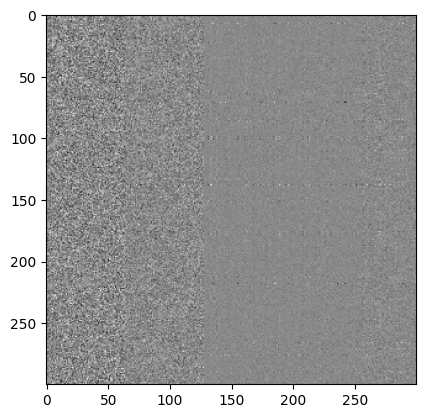

In [15]:
# Examine first layer h.1 attention matrix (300x300)
first_layer = sd_hf['transformer.h.1.attn.c_attn.weight'][:300,:300]
plt.imshow(first_layer, cmap='gray')
plt.show()

In [1]:
# Generate some example sentences which complete short prompts

from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
#generator("West Ham United are ", num_return_sequences=5, truncation=True, max_length=20, max_new_tokens=30)
#generator("Alan Turing is ", num_return_sequences=5, truncation=True, max_length=20, max_new_tokens=30)
generator("Hello, I'm a language model.", num_return_sequences=5, truncation=True, max_length=20, max_new_tokens=30)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=30) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "Hello, I'm a language model. It's not that I'm a model, it's just that I'm a language model, and I want to make all my code more readable and"},
 {'generated_text': "Hello, I'm a language model. I try to write languages in the language model that have a lot of information and I don't want to write languages that are a little bit more complicated"},
 {'generated_text': "Hello, I'm a language model.\n\nPlease allow up to 4 characters (0-9 characters) to be printed on the paper.\n\nI'm not responsible for the spelling"},
 {'generated_text': "Hello, I'm a language model. I use it for the basic syntax of the language, and I'm very familiar with it. I'm also learning to express the language in the next"},
 {'generated_text': "Hello, I'm a language model.\n\nI think the best way to explain this is to define a language model as a set of definitions for language objects.\n\nFor example,"}]

## Our own GPT-2 nn.Module from scratch!

The GPT-2 model architecture is described in Section 2.3 of OpenAI's 2019 GPT-2 paper, "**Language Models are Unsupervised Multitask Learners**" by Radford et al. It follows the the "**Attention is All you Need**" Transformer architecture closely with these modifications:
+ It does not feature the Encoder shown on the left side of the model architecture diagram. 
+ The Decoder stack that reads in the Encoder output is removed from the Decoder.
+ The Layer Norms are reordered to be before the attention blocks - not after.
+ A final Layer Norm is added after the final self-attention block befofre the final calssifier. 

We will examine the schema and naming used in Hugging Face's GPT2LMHeadModel so we can recreate some of the structures. This will allow us to re-use these weights from state.dict() without us having to fully train our own model:
```
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
```
#### Transformer skeleton in GPT class
The transfomer skeleton closely matches the "**Attention is All you Need**" Transformer decoder architecture.
```
self.transformer = nn.ModuleDict(dict(
    wte = nn.Embedding(config.vocab_size, config.n_embed), 
    wpe = nn.Embedding(config.block_size, config.n_embed), 
    h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
    ln_f = nn.LayerNorm(config.n_embed)
))
self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)
```
+ **wte** and **wpe** correspond to the token and positional embeddings that are added together before beign fed into the decoder. Note that the diagram used in the paper refers the token embeddings as **output embeddings**
+ **h** corresponds to the multiple stacked Attention and Layer Norm blocks that will be fleshed out later
+ **ln_f** is the additional final Layer Norm added before the final classifier as mentioned in the GPT-2 paper
+ **lm_head** is the final classifier that selects a final token according to the embeddings that pass through the Transformer

#### Attention and MLP layers in Transformer Blocks
```
x = x + self.attn(self.ln_1(x))
x = x + self.mlp(self.ln_2(x))
```
Note how each block has two sublayers, attention, then MLP (Multi-Layer Perceptron), that are  wrapped in a residual _after_ a LayerNorm is applied to keep the residuals clean:
+ Residual paths (the x being added) are untouched by LayerNorm or nonlinearities.
+ You’re adding the result of a computation onto a stable input signal — not a normalized one.
+ This stabilizes training and improves gradient flow, especially in very deep networks like GPT-2.

The "residuals" are skip connections. The residual is the original input to the block before the **ln_1(x)** or **ln_2(x)** Layer Norm is applied. Adding back the Pre-LayerNormalized **x** that has bit been normalized or distorted ensures the residual is clean. This preserves the "clean" residual pathway, improving training stability and gradient flow. GPT-2 is extremely deep (up to 48 layers in GPT-2 XL), so this matters a lot.

####  MLP feedforward network

In GPT-2 (and Transformers generally), the MLP is a position-wise fully-connected feedforward network (FFN). It operates independently on each token embedding (so no attention or mixing across time). It often uses GELU activation instead of ReLU and is a 2-layer linear network. This is a standard Multi-Layer Perceptron architecture which is just a regular feedforward network (with a fancy historical name)! Here it expands dimensionality by a factor of 4, then projects back.

Adding the residuals **x** back in after the Layer Norms means that there is a clean pathway from the decoder outputs all the way back to the inputs which is important for getting good gradient updates - especially in very deep networks.


#### Multi-headed Self Attention

Self attention operation called from the Transformer Block. The heads run in parallel independently with the results being concatenated. The entire operation is efficient and fast. This implementation is basically covering the same ground as the Self Attention section in Andrej's earlier **Let's Build GPT-2** tutorial. It looks more complicated here because of a few splits which are done for optimization reasons to make best use of PyTorch. The behavior is basically the same. Refer to the other tutorial to see the simpler version. 

The query and key vectors are multiplied together to derive their attention measures ("how interesting they find each other"). This calculates how closely they align in multidemensional vector space. You can see this in the first line of the attention calculations: `q @ k.transpose(-2, -1)`. This is followed by the auto-regressive mask which ensures tokens do not attend to tokens after them in the future. And then this is followed by a Softmax operations so it sums to 1. **v** matrix multiplied with attention, **attn**, then gets added as a weighted sum. `y = y.transpose(1, 2).contiguous().view(B, T, C) ` concatenated the results.

Throughout this section naming is closely following the naming used in the Hugging Face's GPT2LMHeadModel so we can reuse the weights.


#### Forward pass in GPT class

Input to `forward` are token indices, **idx**, of shape (**B**, **T**) where **T** can't be longer than the block size which is the maximum sequence length. This section loads the weights from Hugging Face's GPT2LMHeadModel. The model was stored in a TensorFlow repository which means some of the weights need transposing for use in PyTorch. Andrej identified these weights manually, built a list of the weights that need transposing and then worked through the model layer by layer to transpose as needed.

#### Matching using the HunggingFace model
Earlier we used the following code to access the Hugging Face model to test it out. We need to generate something similar in our own GPT-2 model with the imported weights.
```
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model.", num_return_sequences=5, truncation=True, max_length=20, max_new_tokens=30)
```
We call the model in eval() mode so it isn't being trained. However, the model shouldn't have any layers that change when training or generatging text. This would be different if we were using layers that do change according to mode such as dropout layers.

Topk sampling of 50 is used because that is the Hugging Face default. This causes all probabilities for anything outside of the top 50 to be clamped to 0. This behaviour keeps the GPT-2 model "on track" so it doesn't wander off into unlikely text.

## First Version: Aim to get Hugging Face weights loaded and match their results

In [18]:
# VERSION ONE: GPT-2 USING HUGGING FACE GPT-2 MODEL WEIGHTS

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import inspect

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        # key, query, value projections for all heads but batched
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)          # Project q,k,v in one step
        # output projection of the attention layer
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        # self.c_proj.NANOGPT_SCALE_INIT = 1
        # Regularization
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        # not really a 'bias' - more of a mask. The name is chosen to match OpenAI/HF naming
        # buffers are equivalent to States in MATLAB's custom layers
        # `bias` is a (1, 1, T, T) tensor, useful for broadcasting
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()     # Batch size, sequence length, embedding dimensionality (e_embed)
        # Calculate query, key & values for all heads in batch and move head forward to be the batch
        # nh is "number of heads", hs is "head size", and C is "number of channels" (nh * hs)
        # In GPT-2 (124M), n_head=12, hs=64 so nh*hs = 768 channels in the transformer
        qkv = self.c_attn(x)   # computes query, key & value in parallel. Resulting tensor is (B,T,C) where C = 3 * n_embed
        q, k, v = qkv.split(self.n_embed, dim=2)         # Split the BxTx(3*C) matrix into (B,T,C) chunks where C = n_embed
        # Apply these multi-head operations efficiently in parallel batches
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        
        # Attention (materializes the large (T,T) matrix for all the queries and keys)
        
        # Attention:
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, T, hs) @ (B, nh, hs, T) = (B, nh, T, T)
        att = att.masked_fill(self.bias[:,:, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) --> (B, nh, T, hs)
            
        y = y.transpose(1, 2).contiguous().view(B, T, C) # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, C) where C = nh * hs
        # output projection
        y = self.c_proj(y)
        return y
    
    
# Multi-Layer Perceptron (MLP) position-wise fully-connected feedforward network with two linear projections
# This is called from within the Block function where it is the final step of each transformer block.
# The GELU activation function is similar to ReLU but with a smoother turn around 0. Historically, the tanh approximation
# version of GELU is used as it is faster than standard GELU but Andrej suspects the speed difference is no longer so large.
# Either way, sticking to tanh approximated GELU ensures the model follows the original GPT implementation. BERT uses GELU.
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4 * config.n_embed)    # Linear layer 1
        self.gelu = nn.GELU(approximate='tanh')                      # GELU Activation function with tanh approximation
        self.c_proj = nn.Linear(4 * config.n_embed, config.n_embed)  # Linear layer 2
        self.c_proj.NANOGPT_SCALE_INIT = 1
    
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

    
# Transformer Blocks building Self Attention and MLP feedforawrd layers in nn.ModuleList(). Each block is h.0, h.1, etc
# Note in the initializaion that the Layer Norms are placed before the Self Attention and MLP layers rather than after
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = CausalSelfAttention(config)     # Call attention operation
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)                      # Call MLP operation

    # Forward pass of what the block computes
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))   # Attention applied after Layer Norm with clean residual pathway for adding back x
        x = x + self.mlp(self.ln_2(x))    # Position-wide feedforward applied after Layer Norm with clean residual pathway for x
        return x

    
@dataclass                          # Use decorator to log function calls
class GPTConfig:
    block_size: int = 1024          # GPT2LMHeadModel uses Max sequence length of 1024, `T`
    vocab_size: int = 50257         # GPT2LMHeadModel uses 50257 tokens: 50,000 BPE merges + 256 byte tokens + 1 end of text
    n_layer: int = 12               # GPT2LMHeadModel has 12 hidden layers
    n_head: int = 12                # GPT2LMHeadModel has 12 heads
    n_embed: int = 768              # GPT2LMHeadModel has 768-length embedding

# Transformer architecture following the GPT-2 modification of the Attention is All you Need architecture
# Use schema and naming used in Hugging Face's GPT2LMHeadModel so we can reuse weights from state.dict()
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Match "transformer" naming used GPT2LMHeadModel's container which holds the NN modules so we can easily reuse weights
        # The ModuleDict dictionary allows you to index into the transformer modules using keys
        # The transformer blocks are created as a list 'h' (hidden layer) so each block can be easily indexed with an integer
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embed),             # Token embedding weights
            wpe = nn.Embedding(config.block_size, config.n_embed),             # Positional embedding weights
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # Call transformer blocks ('n_layer' times)
            ln_f = nn.LayerNorm(config.n_embed)                                # Final layer norm
        ))
        # Language Model Head: linear module projects from 768 embeddings to 50,000+ possible tokens used in vocabulary
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False) # Final classifier uses no bias in GPT-2
       
    

    def forward(self, idx, targets=None):                                    # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is {self.config.block_size}"

        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)        # Shape (T) - Train on GPU if available
        pos_emb = self.transformer.wpe(pos)                                  # position embeddings of shape (T, n_embed)
        tok_emb = self.transformer.wte(idx)                                  # token embeddings of shape (B, T, n_embed)
        x = tok_emb + pos_emb                                                # Add position & token embeddings with broadcasting

        # forward through the transformer blocks
        for block in self.transformer.h:
            x = block(x)

        # forward through the final LayerNorm and classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)                                             # (B, T, vocab_size)

        return logits                                                        # Return logits (no loss calcualted yet)
        
## NOTE: the code to this point builds the GPT-2 mode in around 100 lines of code! We will add a few more lines to import
##       the weights from Hugging Face's GPT2LMHeadModel and hopefully have a working GPT-2 generating new text!


    @classmethod
    def from_pretrained(cls, model_type):
        # Load pretrained GPT-2 model weights from Hugging Face
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print(f"Loading weights from pretrained gpt: {model_type}")

        # n_layer, n_head and n_embd hyperparameters are determed from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embed=768),   # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embed=1024),  # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embed=1280),  # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embed=1600),  # 774M params
        }[model_type]
        config_args['vocab_size'] = 50257  # Always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024   # Always 1024 for GPT model checkpoints
        
        # Create from scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()             # Create state_dict for our model and the Hugging Face model
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]  # discard unnecessary buffers (auto regressive masks)
        
        # init a Hugging Face transformer model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # Copy Hugging Face model keys while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')]  # ignore these
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')]         # ignore these

        # The Hugging Face model is from a TensorFlow repository where some weights are transposed so that needs fixing.
        # In other words, the OpenAI implementation uses a conv1D rather than a vanilla linear layer which requires a fix.
        # Manually make a list of weights that require transposing
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        # As stated above, the OpenAI checkpoints use a conv1D module, but we only want to use a vanilla linear layer
        # This means that we have to transpose weights when we import them if they are in the manually built list above
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy as-is the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

#### Call the model to test it runs

In [20]:
model = GPT.from_pretrained('gpt2')
print ("didn't crash yay!")
print(GPT)

Loading weights from pretrained gpt: gpt2
didn't crash yay!
<class '__main__.GPT'>


### Run the model to generate some text samples

This is similar to how we first tested the Hugging Face model when we started this tutorial

In [24]:
num_return_sequences = 5
max_length = 30

model = GPT.from_pretrained('gpt2')         # Initialize model
model.eval()                                # Put model in evaluation mode which is good practice when it isn't being trained
model.to('cuda')                            # Run efficiently on GPU if available - move entire model and its tensors to GPU

# Prefix tokens
import tiktoken

enc = tiktoken.get_encoding('gpt2')                              # GPT-2 tokenizer
tokens = enc.encode("Hello, I'm a language model,")              # Encode starter phrase as list of 8 integer tokens
tokens = torch.tensor(tokens, dtype=torch.long)                  # Form tensor from encoding tokens (8, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)     # Replicate the tokens times (5, 8)
x = tokens.to('cuda')                                            # Transfer initial input (idx) to GPU where model is situated

# Generate right now x is (B, T) where B=5 and T=8. 
torch.manual_seed(42)                                            # Set seed to 42
torch.cuda.manual_seed(42)                                       # Match seed on GPU
while x.size(1) < max_length:
    # Forward thge model to get the logits
    with torch.no_grad():                                        # no_grad means don't call backpropagation so less processing
        logits = model(x)                                        # (B, T, vocab_size)
        logits = logits[:, -1, :]                                # (B, vocab_size) - logits at the last position
        probs = F.softmax(logits, dim=-1)                        # Get the probabilities
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # top-k sampling of 50 - topk_probs/indices become (5, 50)
        ix = torch.multinomial(topk_probs,1)                     # (B, 1) - Select a token from the top-k probabilities
        xcol = torch.gather(topk_indices, -1, ix)                # (B, 1) - Gather corresponding indices
        x = torch.cat((x, xcol), dim=1)                          # Append the sequence
    
# Print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()                          # Get the tokens from all of the 5 samples 
    decoded = enc.decode(tokens)                                 # Use tiktoken's decoder to convert tokens back to characters
    print(">", decoded)

Loading weights from pretrained gpt: gpt2
> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
